In [ ]:
#Importo il modulo drive fornito da Colab per interagire con Google Drive.
from google.colab import drive

#Monta Google Drive nella directory locale /content/drive con stato "pulito".
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
global_var = {
    # PARAMETRI DI CARICAMENTO / PREPROCESSING DEI DATI:
    "batch_size": 128,       #Campioni per batch.
    "n_workers": 2,         #Worker del DataLoader per prefetch/parallelo.
    "max_seq_len": 1024,    #Lunghezza massima; testi lunghi verranno troncati, corti paddati con <pad>.

    # PARAMETRI DEL MODELLO (TextCNN):
    "embedding_dim": 256,             #Più dimensione embedding per capacità semantica.
    "cnn_num_filters": 256,           #Più numero filtri per finestra conv.
    "cnn_kernel_sizes": [3,4,5,7],    #Aggiunto kernel più largo (7) per frasi lunghe.
    "mlp_hidden_dim": 256,            #Più Neuroni nel layer MLP.
    "output_dim": 2,                  #Classi: 0 = Human, 1 = GenAI.
    "dropout": 0.5,                   #Dropout più leggero per non underfittare.

    # PARAMETRI DI TRAINING:
    "learning_rate": 5e-4,            #LR più piccolo per training stabile.
    "epochs": 15,                     #Più epoche (con early stopping).
    "weight_decay": 1e-5,             #Penalità L2 più lieve.
    "label_smoothing": 0.05,          #Smoothing CE (calibrazione).

    # VALIDAZIONE / EARLY STOP:
    "val_size": 0.2,              #Quota validation sul training set.
    "patience": 3                 #Early stopping più paziente.
}

In [ ]:
# STANDARD LIBRARY:
import os                         #Interazione con il file system.
import math                       #Funzioni matematiche base.
import copy                       #Copie profonde/shallow di oggetti.
import re                         #Espressioni regolari (regex).
import random                     #Generatore di numeri casuali.
from collections import Counter   #Conta frequenze di elementi.

# NUMERICO / TABELLARE:
import numpy as np               #Calcolo numerico vettoriale/matriciale.
import pandas as pd              #Strutture tabellari (DataFrame).

# VISUALIZZAZIONE:
import matplotlib.pyplot as plt  #Grafici base.
import seaborn as sns            #Grafici statistici (es. heatmap).

# PROGRESS BAR:
from tqdm.notebook import tqdm   #Barra di avanzamento elegante per loop.

# PyTorch:
import torch                                              #Tensori, GPU, operazioni autograd.
import torch.nn as nn                                     #Moduli per costruzione di reti neurali.
import torch.nn.functional as F                           #Funzioni di attivazione, loss, etc.
from torch.utils.data import Dataset, DataLoader, Subset  #Gestione dataset e batching.
from torch.cuda.amp import autocast, GradScaler           #Mixed precision training (accelerazione su GPU).

# SCIKIT-LEARN:
from sklearn.model_selection import train_test_split      #Split training / validation.
from sklearn.metrics import (
    accuracy_score,                             #Accuratezza.
    balanced_accuracy_score,                    #Accuratezza bilanciata per classi sbilanciate.
    f1_score,                                   #F1-score.
    precision_recall_fscore_support,            #Precision, recall, f1 per classe.
    confusion_matrix,                           #Matrice di confusione.
    classification_report,                      #Report testuale completo.
    recall_score                                # Added recall_score
)

In [ ]:
#Se hai una GPU NVIDIA disponibile e PyTorch con build CUDA, usa "cuda:0".
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"[LOG] Device → {device}")

[LOG] Device → cpu


In [ ]:
def collate_trim(batch):
    """
    Collate function personalizzata per NLP con sequenze padded.
    Rimuove il padding tagliando tutte le sequenze del batch alla lunghezza massima effettiva (senza 0).

    Input: lista di tuple (x: [T_max], y: int)
    Output:
      - xs_trim: tensore [B, L_batch] trimmato
      - ys: etichette [B]
    """
    xs, ys = zip(*batch)
    lens = [int((x != 0).sum().item()) for x in xs]           #Lunghezze reali.
    Lb = max(1, max(lens)) if lens else 1                     #Max lunghezza reale.
    xs_trim = torch.stack([x[:Lb] for x in xs])               #Troncamento dinamico.
    ys = torch.stack(ys)
    return xs_trim, ys

def make_loader(dataset, batch_size, shuffle):
    """
    Costruisce un DataLoader con:
      - collate_fn = collate_trim (dynamic padding)
      - pin_memory per trasferimenti GPU più rapidi
      - persistent_workers + prefetch_factor (se n_workers > 0)
    """
    kwargs = {}
    if global_var["n_workers"] > 0:
        kwargs["persistent_workers"] = True
        kwargs["prefetch_factor"] = 4           #Più batch prefetchati per ridurre attese I/O.
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=global_var["n_workers"],
        pin_memory=(device.type == "cuda"),
        collate_fn=collate_trim,
        **kwargs
    )

In [ ]:
PAD, UNK = "<pad>", "<unk>"                             #Token speciali: <pad> (id 0) e <unk> (id 1) riservati.
_token_re = re.compile(r"\b\w+\b", flags=re.UNICODE)    #Regex Unicode: cattura parole alfanumeriche tra confini di parola.

def basic_tokenizer(text: str):                         #Funzione di tokenizzazione minimal basata su regex.
    return _token_re.findall(str(text).lower())         #Lowercase + estrazione dei token; punteggiatura rimossa.

def build_vocab(text_iter, min_freq: int = 1):          #Costruisce il vocabolario da un iterabile di righe di testo.
    counter = Counter()                                 #Multinsieme di frequenze dei token.
    for line in text_iter:                              #Passata unica su tutte le righe.
        counter.update(basic_tokenizer(line))           #Aggiunge i token della riga al contatore.
    vocab = {PAD: 0, UNK: 1}                            #Inizializza il mapping con gli ID riservati.
    for tok, c in counter.most_common():                #Scorre i token per frequenza decrescente.
        if c >= min_freq:                               #Soglia minima di frequenza (filtra rumore/rari).
            vocab[tok] = len(vocab)                     #Assegna ID progressivo corrente.
    return vocab

In [ ]:
class TextDataset(Dataset):
    def __init__(self, csv_path: str, vocab: dict | None = None):  #Estende torch.utils.data.Dataset.
        df = pd.read_csv(csv_path)                                 #1) Carica il CSV in un DataFrame;
        self.texts  = df["text"].astype(str).tolist()              #2) Colonna 'text' --> lista di stringhe;
        self.labels = df["label"].astype(int).tolist()             #3) Colonna 'label' --> lista di int;
        self.vocab  = vocab or build_vocab(self.texts)             #4) Usa vocabolario passato, altrimenti ne viene costruito uno da zeo.

    def __len__(self):                                             #Obbligatorio, per la lunghezza del dataset.
        return len(self.labels)

    def encode(self, text: str):                                             #Converte stringa in tensor di ID.
        ids = [self.vocab.get(t, self.vocab[UNK])                            #1) token --> id (UNK se assente);
               for t in basic_tokenizer(text)][: global_var["max_seq_len"]]  #2) Tronca a max_seq_len;
        ids += [self.vocab[PAD]] * (global_var["max_seq_len"] - len(ids))    #3) pad fino a max_seq_len;
        return torch.tensor(ids, dtype=torch.long)                           #4) Restituisce tensor long [T].

    def __getitem__(self, idx):                                    #Obbligatorio, per l'item i-esimo.
        return self.encode(self.texts[idx]), \
               torch.tensor(self.labels[idx])

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)                          #Seed per il RNG della stdlib Python.
    np.random.seed(seed)                       #Seed per NumPy (operazioni vettoriali).
    torch.manual_seed(seed)                    #Seed per PyTorch su CPU.
    torch.cuda.manual_seed_all(seed)           #Seed per tutte le GPU CUDA (se presenti).
    #Modalità deterministica per cuDNN: risultati ripetibili, a scapito di alcune ottimizzazioni.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)                   #Fissa tutti i generatori per ripetibilità.

# PERCORSI DEI DATASET (CSV):
TRAIN_CSV = "/content/drive/MyDrive/TESI-Classificazione/MIO/dt_train_art&mh.csv"
EVAL_CSV  = "/content/drive/MyDrive/TESI-Classificazione/MIO/dt_test_art&mh.csv"
TEST_CSV  = "/content/drive/MyDrive/TESI-Classificazione/MIO/it_dev_full.csv"

# 1) VOCABOLARIO SOLO SUL TRAIN (no leakage)
full_train = TextDataset(TRAIN_CSV)
vocab = full_train.vocab
print(f"[LOG] Vocabulary size (from TRAIN): {len(vocab)}")

# 2) DATASET DI VALIDATION E TEST (riusano il vocab del TRAIN)
eval_dataset = TextDataset(EVAL_CSV, vocab=vocab)   # 30 esempi
test_dataset = TextDataset(TEST_CSV, vocab=vocab)   # 60 esempi

# 3) DATALOADER (niente split dal train)
train_loader = make_loader(full_train,   global_var["batch_size"], shuffle=True)
val_loader   = make_loader(eval_dataset, global_var["batch_size"], shuffle=False)
test_loader  = make_loader(test_dataset, global_var["batch_size"], shuffle=False)

# (opzionale) sanity check
import pandas as pd
print("[CHECK] VALIDATION rows =", len(pd.read_csv(EVAL_CSV)))
print("[CHECK] TEST rows =", len(pd.read_csv(TEST_CSV)))

[LOG] Vocabulary size (from TRAIN): 2641
[CHECK] VALIDATION rows = 60
[CHECK] TEST rows = 1843


In [ ]:
class TextCNN(nn.Module):
    """
    TextCNN potenziata con:
      - Conv1D parallele (kernel multipli)
      - Global Max Pooling
      - MLP con ReLU e Dropout
    """
    def __init__(self,
                 vocab_size: int,             #Numero di token unici nel vocabolario.
                 emb_dim: int,                #Dimensione vettori embedding.
                 num_filters: int,            #Numero di filtri per ciascun kernel.
                 kernel_sizes: list[int],     #Dimensioni kernel convoluzionali.
                 mlp_hidden_dim: int,         #Dimensione del layer MLP nascosto.
                 num_classes: int,            #Numero di classi finali (output).
                 dropout: float = 0.2,        #Probabilità di dropout.
                 padding_idx: int = 0):       #Indice per <PAD>, escluso dalla training.
        super().__init__()

        #Embedding layer con padding_idx che "freeza" il vettore del token <PAD>.
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)

        #Lista di convoluzioni 1D parallele, una per ogni kernel size.
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=emb_dim,          #Canali in ingresso = dimensione embedding.
                out_channels=num_filters,     #Ogni kernel genera num_filters feature-map.
                kernel_size=k                 #Lunghezza del kernel.
            )
            for k in kernel_sizes
        ])

        #Dimensione del vettore concatenato dopo pooling.
        conv_out_dim = num_filters * len(kernel_sizes)

        #Primo layer fully-connected (MLP).
        self.fc1 = nn.Linear(conv_out_dim, mlp_hidden_dim)

        #Secondo layer fully-connected (logits output).
        self.fc2 = nn.Linear(mlp_hidden_dim, num_classes)

        #Dropout layer per regolarizzazione.
        self.drop = nn.Dropout(dropout)

        #ReLU come funzione di attivazione.
        self.act  = nn.ReLU()

    def forward(self, x):
        #Input: x ∈ [B, T], dove 0 = token <PAD>.

        emb = self.embedding(x)                 #[B, T, E] --> embedding dei token.
        emb = emb.transpose(1, 2)               #[B, E, T] --> per compatibilità con Conv1D.

        pooled = []                             #Lista dei vettori pooled da ciascun ramo.

        for conv in self.convs:
            h = self.act(conv(emb))             #[B, F, T'] --> convoluzione e ReLU.
            p = torch.amax(h, dim=2)            #[B, F] --> global max pooling sulla dimensione T'.
            pooled.append(p)                    #Salva output del ramo.

        feat = torch.cat(pooled, dim=1)          #[B, F * n_kernels] --> concatenazione dei rami.

        h = self.drop(self.act(self.fc1(feat)))     #[B, H] --> MLP e ReLU e Dropout.
        h = self.drop(h)                            #Ulteriore dropout (stacked).
        logits = self.fc2(h)                        #[B, K] --> output finale (logits).

        return logits

In [ ]:
# ============================================================
# TRAINING CON PESI DI CLASSE SEMPRE ATTIVI + EARLY STOP
# ============================================================

# Calcolo sbilanciamento
cnt = Counter(full_train.labels)
tot = len(full_train)
print(f"[LOG] Distribuzione classi TRAIN: {cnt}")

# Definizione loss con pesi di classe + smoothing
w = torch.tensor([tot/cnt[0], tot/cnt[1]], dtype=torch.float, device=device)
loss_fn = nn.CrossEntropyLoss(weight=w, label_smoothing=0.1)
print("[LOG] Uso class weights e label smoothing=0.1")

# Istanzia il modello TextCNN
model = TextCNN(
    vocab_size=len(vocab),
    emb_dim=global_var["embedding_dim"],
    num_filters=global_var["cnn_num_filters"],
    kernel_sizes=global_var["cnn_kernel_sizes"],
    mlp_hidden_dim=global_var["mlp_hidden_dim"],
    num_classes=global_var["output_dim"],
    dropout=0.5,          # più dropout per regolarizzazione
    padding_idx=0
).to(device)

# Ottimizzatore e scheduler
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=3e-4,                       # LR più basso per training stabile
    weight_decay=global_var["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

# Funzione di training con AMP + early stopping
def train_amp(model, train_loader, val_loader, epochs, patience=3):
    scaler = torch.amp.GradScaler(enabled=(device.type == "cuda"))
    history = {"train": [], "val": []}
    best_val = math.inf
    best_state = None
    bad = 0

    for ep in range(epochs):
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, unit="batch", desc=f"Epoch {ep+1}/{epochs} [train]")
        for bx, by in pbar:
            bx = bx.to(device, non_blocking=True)
            by = by.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
                logits = model(bx)
                loss = loss_fn(logits, by)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            running += loss.item()
            pbar.set_postfix(loss=running / (pbar.n + 1))

        # VALIDAZIONE
        model.eval()
        val_loss = 0.0
        with torch.inference_mode(), torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
            for bx, by in val_loader:
                bx = bx.to(device, non_blocking=True)
                by = by.to(device, non_blocking=True)
                val_loss += loss_fn(model(bx), by).item()
        val_loss /= max(1, len(val_loader))

        history["train"].append(running / max(1, len(train_loader)))
        history["val"].append(val_loss)
        print(f"[LOG] Ep{ep+1}: train={history['train'][-1]:.4f} | val={val_loss:.4f}")

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(f"[LOG] Early stop a epoca {ep+1} (best val={best_val:.4f}).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return history

# Avvio training
history = train_amp(model, train_loader, val_loader,
                    epochs=15, patience=3)

[LOG] Distribuzione classi TRAIN: Counter({0: 100, 1: 99})
[LOG] Uso class weights e label smoothing=0.1


Epoch 1/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep1: train=0.7433 | val=0.6846


Epoch 2/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep2: train=0.6480 | val=0.7549


Epoch 3/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep3: train=0.5379 | val=0.6228


Epoch 4/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep4: train=0.4765 | val=0.5812


Epoch 5/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep5: train=0.4420 | val=0.5533


Epoch 6/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep6: train=0.3830 | val=0.5431


Epoch 7/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep7: train=0.3386 | val=0.5005


Epoch 8/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep8: train=0.2926 | val=0.4396


Epoch 9/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep9: train=0.2822 | val=0.4090


Epoch 10/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep10: train=0.2621 | val=0.3954


Epoch 11/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep11: train=0.2437 | val=0.3583


Epoch 12/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep12: train=0.2269 | val=0.3291


Epoch 13/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep13: train=0.2302 | val=0.3156


Epoch 14/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep14: train=0.2240 | val=0.3081


Epoch 15/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep15: train=0.2263 | val=0.3059


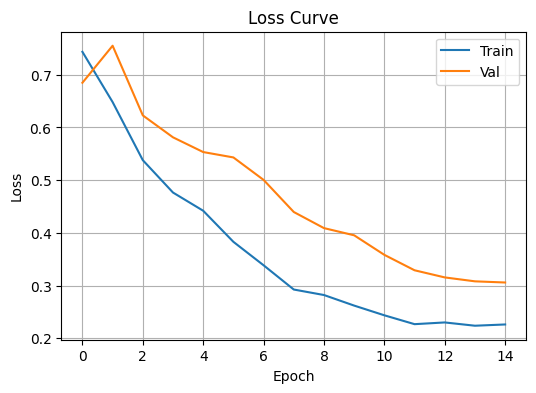

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history["train"], label="Train")
plt.plot(history["val"],   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve")
plt.legend(); plt.grid(True); plt.show()

In [ ]:
def evaluate_loader(model, loader, label_names=("HUMAN", "GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    """
    Valutazione di un modello su un DataLoader.
    Supporta temperature scaling, soglia custom e visualizzazione confusion matrix.
    """
    model.eval()                      #Modalità valutazione.
    y_true, y_pred = [], []

    with torch.inference_mode():      #No gradienti.
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature         #Softmax scaling.

            if threshold is None:
                pred = logits.argmax(1).cpu().numpy()           #Classico argmax.
            else:
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()         #Probabilità classe 1.
                pred = (p1 >= threshold).astype(int)                      #Threshold manuale.

            y_pred.extend(pred)
            y_true.extend(by.cpu().numpy().tolist()) # Convert to list to avoid numpy deprecation warning

    # CALCOLO DELLE METRICHE:
    report = classification_report(
        y_true, y_pred, target_names=list(label_names),
        output_dict=True, digits=4
    )
    cm = confusion_matrix(y_true, y_pred)

    # VISUALIZZAZIONE DELLA MATRICE DI CONFUSIONE, SE RICHIESTO:
    if plot_cm:
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(ttl)
        plt.tight_layout()
        plt.show()

    return report, cm

In [ ]:
def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN", "GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    """
    Wrapper di valutazione da un file CSV. Crea il dataset e richiama evaluate_loader.
    """
    batch_size = batch_size or global_var["batch_size"]
    ds = TextDataset(csv_path, vocab=vocab)
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)

    rep, cm = evaluate_loader(
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )
    return rep, cm, len(ds)  #Report, matrice, numero di campioni.

In [ ]:
def evaluate_loader(model, loader, label_names=("HUMAN", "GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    """
    Valuta SEMPRE con confusion matrix 2x2, anche se il dataset è monoclasse.
    """
    model.eval()
    y_true_list, y_pred_list = [], []

    with torch.inference_mode():
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature
            if threshold is None:
                pred = logits.argmax(1)
            else:
                p1 = F.softmax(logits, dim=1)[:, 1]
                pred = (p1 >= threshold).long()

            y_pred_list.append(pred.cpu())
            y_true_list.append(by.cpu())

    y_true = torch.cat(y_true_list).numpy()
    y_pred = torch.cat(y_pred_list).numpy()

    # SEMPRE 2x2: forza labels=[0,1] anche se manca una classe
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Report: forziamo zero_division=0 per evitare warning se manca una classe
    report = classification_report(
        y_true, y_pred, target_names=list(label_names),
        output_dict=True, digits=4, zero_division=0
    )

    if plot_cm:
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(ttl)
        plt.tight_layout()
        plt.show()

    return report, cm

def calibrate_temperature(model, val_loader, device):
    model.eval()                                          #Modalità eval: disabilita dropout/batchnorm.
    logits_list, labels_list = [], []                     #Accumulatori per logits e label su tutta la VAL.
    with torch.inference_mode():                          #No grad, mem/compute più leggeri nel loop.
        for bx, by in val_loader:
            logits_list.append(model(bx.to(device)))      #Forward --> logits [B,C].
            labels_list.append(by.to(device))             #Salva etichette corrispondenti [B].

    logits = torch.cat(logits_list)                       #[N,C] tutti i logits di VAL.
    labels = torch.cat(labels_list)                       #[N]   tutte le label di VAL.

    unique_labels = torch.unique(labels)

    if len(unique_labels) < 2:
        print("[VAL] Validation data has only one class. Skipping temperature calibration.")
        return 1.0 # Default temperature

    nll = nn.CrossEntropyLoss()                                     #NLL su logits non normalizzati.
    logT = torch.tensor(0.0, device=device, requires_grad=True)     #Param: logT.
    optimizer = torch.optim.LBFGS([logT], lr=0.5, max_iter=50)      #L-BFGS per unidimensionale.

    def closure():
        optimizer.zero_grad()                             # richiesto da L-BFGS.
        T = torch.exp(logT)                               # Temperatura positiva.
        loss = nll(logits / T, labels)                    # NLL con scaling dei logits.
        loss.backward()                                   # Gradiente rispetto a logT.
        return loss

    optimizer.step(closure)                               # Esegue le iterazioni L-BFGS.
    T = torch.exp(logT).item()                            # Estrae T scalare (float).
    print(f"[VAL] temperatura ottima T={T:.3f}")          # Log del valore trovato.
    return T

def tune_threshold_for_monoclasse(model, loader, device, temperature=1.0, positive_label=1):
    """
    Cerca la soglia che massimizza il recall della classe positiva (es. GenAI).
    """
    model.eval()
    y_true_list, y_prob_list = [], []
    with torch.inference_mode():
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature
            p1 = F.softmax(logits, dim=1)[:, positive_label]
            y_prob_list.append(p1.cpu())
            y_true_list.append(by.cpu())

    y_true = torch.cat(y_true_list).numpy()
    y_prob = torch.cat(y_prob_list).numpy()


    best_t, best_recall = 0.5, -1.0
    for t in np.linspace(0.05, 0.95, 181):  # step fine
        y_hat = (y_prob >= t).astype(int)
        recall_pos = recall_score(y_true, y_hat, pos_label=positive_label)
        if recall_pos > best_recall:
            best_recall, best_t = recall_pos, t

    print(f"[TUNING-MONOCLASSE] soglia ottima t*={best_t:.3f} (Recall GenAI={best_recall:.3f})")
    return best_t

# --- Calibrazione su validation
T_eval = calibrate_temperature(model, val_loader, device)

# --- Se validation è bilanciata → tuning normale; se test è monoclasse → tuning recall GenAI
if len(np.unique(torch.cat([by.cpu() for bx, by in test_loader]).numpy())) == 1:   # controlla se TEST è monoclasse
    t_eval_star = tune_threshold_for_monoclasse(model, test_loader, device,
                                                temperature=T_eval, positive_label=1)
else:
    t_eval_star = tune_threshold_for_monoclasse(model, val_loader, device,
                                                temperature=T_eval, positive_label=1)

# override manuale
if global_var.get("DECISION_THRESHOLD_OVERRIDE") is not None:
    t_eval_star = float(global_var["DECISION_THRESHOLD_OVERRIDE"])

# Need to define rep_val and n_val before using them here.
# Assuming you want to evaluate on the validation set before the final test set evaluation.
# Let's add evaluation on the validation set here.
n_val = len(eval_dataset) # Define n_val here
n_test = len(test_dataset) # Define n_test here
print(f"\n[LOG] Validation su {os.path.basename(EVAL_CSV)}")
rep_val, cm_val, n_val = evaluate_csv(
    model, EVAL_CSV, vocab=vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T_eval, threshold=t_eval_star,
    plot_cm=False, title_suffix=f"(VAL, {n_val} | T={T_eval:.2f}, t*={t_eval_star:.2f})"
)

if 'macro avg' in rep_val:
    print(
        f"Accuracy: {rep_val['accuracy']:.4f}  |  "
        f"F1 macro: {rep_val['macro avg']['f1-score']:.4f}  |  "
        f"Precision macro: {rep_val['macro avg']['precision']:.4f}  |  "
        f"Recall macro: {rep_val['macro avg']['recall']:.4f}"
    )
else:
    print(f"Accuracy: {rep_val['accuracy']:.4f}")

[VAL] temperatura ottima T=0.107


/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


[TUNING-MONOCLASSE] soglia ottima t*=0.050 (Recall GenAI=0.417)

[LOG] Validation su dt_test_art&mh.csv
Accuracy: 0.9833  |  F1 macro: 0.9833  |  Precision macro: 0.9839  |  Recall macro: 0.9833


In [ ]:
# PATH SU GOOGLE DRIE DOVE EFFETTUARE IL SALVATAGGIO:
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"
os.makedirs(BASE, exist_ok=True)        #Crea la directory se non esiste.

# SE NON ESISTE 'val_loader', VIENE ASSEGNATO 'test_loader' COME FALLBACK:
try:
    val_loader
except NameError:
    val_loader = test_loader

def extract_vocab(obj):
    """
    Risale ricorsivamente una catena .dataset fino a trovare un attributo 'vocab'.
    Utile per recuperare automaticamente il vocabolario da un DataLoader o Dataset.
    """
    seen = set()
    while obj is not None and id(obj) not in seen:
        seen.add(id(obj))
        if hasattr(obj, "vocab"):
            return obj.vocab
        obj = getattr(obj, "dataset", None)
    return None     #Se non lo trova.

# SI PROVA A RECUPERARE IL VOCABOLARIO DA OGGETTI NOTI (in RAM):
base_vocab = None
for cand in [globals().get("train_dataset"), globals().get("full_train"),
             globals().get("train_loader")]:
    base_vocab = extract_vocab(cand)
    if base_vocab is not None:
        break

# SE NON E' STATO TROVATO, SI USA VARIABILE 'vocab' GLOBALE:
if base_vocab is None and "vocab" in globals():
    base_vocab = vocab

# SE E' ANCORA ASSENTE, SI PROVA A RICOSTRUIRE DA TRAIN_CSV:
if base_vocab is None and "TRAIN_CSV" in globals():
    print("[WARN] Ricostruisco vocab dal TRAIN_CSV (potenziale mismatch).")
    base_vocab = TextDataset(TRAIN_CSV).vocab

# SE IL TUTTO FALLISCE, VIENE INTERROTTO TUTTO CON CONSEGUENTE ERRORE:
if base_vocab is None:
    raise RuntimeError("Vocabolario del training non reperito: definisci 'vocab' o tieni in RAM 'train_dataset'/'train_loader'.")

print(f"[LOG] Vocab recuperato (size={len(base_vocab):,}).")

def evaluate_loader(model, loader, label_names=("HUMAN", "GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    """
    Valuta su loader. Se y_true è monoclasse (es. solo GenAI), usa un
    reporting dedicato (niente macro-F1) ed evita i warning sklearn.
    """
    model.eval()
    y_true, y_pred = [], []

    with torch.inference_mode():
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature
            if threshold is None:
                pred = logits.argmax(1).cpu().numpy()
            else:
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)

            y_pred.extend(pred)
            y_true.extend(by.cpu().numpy().tolist())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # ====== CASO MONOCLASSE (true) ======
    if len(np.unique(y_true)) == 1:
        pos = int(np.unique(y_true)[0])              # etichetta presente (qui: 1 = GenAI)
        neg = 1 - pos
        tp = int(np.sum(y_pred == pos))
        fn = int(np.sum(y_pred == neg))
        n  = len(y_true)

        recall_pos = tp / max(1, (tp + fn))          # == accuracy in monoclasse
        fnr_pos    = fn / max(1, (tp + fn))
        precision_pos = 1.0                          # nessun vero negativo ⇒ nessun FP

        report = {
            "single_class_true": True,
            "positive_label": pos,
            "n_samples": n,
            "tp": tp, "fn": fn,
            "accuracy": recall_pos,
            "recall_pos": recall_pos,
            "fnr_pos": fnr_pos,
            "precision_pos": precision_pos
        }

        # matrice 1x2: [FN, TP] sulla riga della classe presente
        cm = np.array([[fn, tp]], dtype=int)

        if plot_cm:
            xticks = [label_names[neg], label_names[pos]]
            yticks = [label_names[pos]]
            plt.figure(figsize=(5, 2.8))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=xticks, yticklabels=yticks)
            ttl = "Confusion Matrix (monoclasse true)" + (f" {title_suffix}" if title_suffix else "")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title(ttl)
            plt.tight_layout()
            plt.show()

        return report, cm

    # ====== CASO MULTICLASSE (true) ======
    # (come prima, report classico)
    report = classification_report(
        y_true, y_pred, target_names=list(label_names),
        output_dict=True, digits=4
    )
    cm = confusion_matrix(y_true, y_pred)

    if plot_cm:
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm

def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN", "GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    """
    Wrapper di valutazione da un file CSV. Crea il dataset e richiama evaluate_loader.
    """
    batch_size = batch_size or global_var["batch_size"]
    ds = TextDataset(csv_path, vocab=vocab)
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)

    rep, cm = evaluate_loader(
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )
    return rep, cm, len(ds)  #Report, matrice, numero di campioni.

[LOG] Vocab recuperato (size=2,641).


[CHECK] VALIDATION rows = 60
[CHECK] TEST rows       = 1843
[VAL] temperatura ottima T=0.107
[TUNING-MONOCLASSE] soglia ottima t*=0.050 (Recall GenAI=0.417)


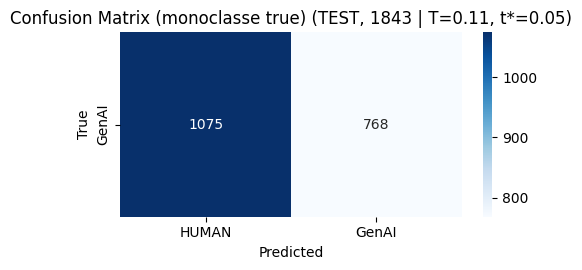


[LOG] Test su it_dev_full.csv — campioni: 1843
[MONOCLASSE TRUE: GenAI] TP=768  |  FN=1075  |  Accuracy/Recall GenAI: 0.4167  |  FNR: 0.5833  |  Precision 1.0000


In [ ]:
TEST_CSV = f"{BASE}/it_dev_full.csv"   # TEST (60)

# Sanity check sui file esistenti
assert os.path.exists(EVAL_CSV), f"File di VALIDATION non trovato: {EVAL_CSV}"
assert os.path.exists(TEST_CSV),  f"File di TEST non trovato: {TEST_CSV}"
print(f"[CHECK] VALIDATION rows = {len(pd.read_csv(EVAL_CSV))}")
print(f"[CHECK] TEST rows       = {len(pd.read_csv(TEST_CSV))}")
# ---------------------------------------------------------
# 1) Calibrazione della temperatura e tuning soglia
# ---------------------------------------------------------
T_eval = calibrate_temperature(model, val_loader, device)

# --- Se validation è bilanciata → tuning normale; se test è monoclasse → tuning recall GenAI
if len(np.unique(torch.cat([by.cpu() for bx, by in test_loader]).numpy())) == 1:   # controlla se TEST è monoclasse
    t_eval_star = tune_threshold_for_monoclasse(model, test_loader, device,
                                                temperature=T_eval, positive_label=1)
else:
    t_eval_star = tune_threshold_for_monoclasse(model, val_loader, device,
                                                temperature=T_eval, positive_label=1)

if global_var.get("DECISION_THRESHOLD_OVERRIDE") is not None:
    t_eval_star = float(global_var["DECISION_THRESHOLD_OVERRIDE"])

# ---------------------------------------------------------
# 2) Valutazione FINALE su TEST
# ---------------------------------------------------------
rep_test, cm_test, n_test = evaluate_csv(
    model, TEST_CSV, vocab=vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T_eval, threshold=t_eval_star,
    plot_cm=True, title_suffix=f"(TEST, {n_test} | T={T_eval:.2f}, t*={t_eval_star:.2f})"
)

print(f"\n[LOG] Test su {os.path.basename(TEST_CSV)} — campioni: {n_test}")

if rep_test.get("single_class_true", False):
    lab = rep_test["positive_label"]
    lab_name = ("HUMAN","GenAI")[lab]
    print(f"[MONOCLASSE TRUE: {lab_name}] "
          f"TP={rep_test['tp']}  |  FN={rep_test['fn']}  |  "
          f"Accuracy/Recall {lab_name}: {rep_test['recall_pos']:.4f}  |  "
          f"FNR: {rep_test['fnr_pos']:.4f}  |  "
          f"Precision {rep_test['precision_pos']:.4f}")
else:
    print(
        f"Accuracy: {rep_test['accuracy']:.4f}  |  "
        f"F1 macro: {rep_test['macro avg']['f1-score']:.4f}  |  "
        f"Precision macro: {rep_test['macro avg']['precision']:.4f}  |  "
        f"Recall macro: {rep_test['macro avg']['recall']:.4f}"
    )

In [ ]:
# Si rileva BASE, laddove non fosse definita.
if 'BASE' not in locals():
    for _p in ["/content/drive/MyDrive/TESI-Classificazione/MIO",
               "/content/drive/MyDrive/TEST-Classificazione/MIO"]:
        if os.path.isdir(_p):
            BASE = _p
            break

TEST_CSV = f"{BASE}/it_dev_full.csv"
assert os.path.exists(TEST_CSV), f"File non trovato: {TEST_CSV}"

# DATALOADER TEST, RIUSANDO IL VOCAB DEL TRAIN:
test_ds = TextDataset(TEST_CSV, vocab=base_vocab)
test_dl = make_loader(test_ds, batch_size=global_var["batch_size"], shuffle=False)

# INFERENCE CON T_eval E SOGLIA t_eval_star (ora ottimizzata anche per monoclasse)
probs, preds = [], []
model.eval()
with torch.inference_mode():
    for bx, _ in test_dl:
        logits = model(bx.to(device)) / T_eval
        p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        probs.extend(p1.tolist())
        preds.extend((p1 >= t_eval_star).astype(int).tolist())

# TABELLA ORDINATA (errori in alto) + prob. formattata IT (virgola, 7 decimali)
df_src = pd.read_csv(TEST_CSV)
map_lab = {0: "HUMAN", 1: "GenAI"}
df_out = pd.DataFrame({
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),
    "true_id": df_src["label"].astype(int),
    "pred_id": np.array(preds, dtype=int),
    "prob_genai": np.array(probs, dtype=np.float64)
})
df_out["true"] = df_out["true_id"].map(map_lab)
df_out["pred"] = df_out["pred_id"].map(map_lab)
df_out["correct"] = np.where(df_out["true_id"] == df_out["pred_id"], "✓", "✗")

def format_it(x: float, decimals: int = 7) -> str:
    return f"{float(x):.{decimals}f}".replace('.', ',')
df_out["prob_genai_it"] = df_out["prob_genai"].map(lambda v: format_it(v, 7))

# ORDINAMENTO: errori prima, poi prob_genai decrescente
df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"] == "✓").astype(int)
df_view = df_view.sort_values(["err_rank","prob_genai"], ascending=[True, False]).drop(columns=["err_rank"])

# PREVIEW COMPLETA (mostra tutte le righe)
pd.set_option("display.max_colwidth", 160)
pd.set_option("display.max_rows", 1000)
display_cols = [c for c in ["id","topic"] if c in df_view.columns] \
             + ["text","true","pred","prob_genai_it","correct"]
print(f"[INFO] TEST — mostro tutte le {len(df_view)} righe (errori in alto). Il file completo viene salvato su Drive.\n")
display(df_view[display_cols])

# SALVATAGGIO CSV VERSIONATO CON T e t* (formato europeo)
fname = f"test_predictions_art&mh_T{T_eval:.2f}_t{t_eval_star:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8", sep=';', decimal=',')
print("[LOG] File completo salvato in:", save_path)

# SECONDO RIQUADRO: SOLO ERRORI (mostra tutti)
df_errors = df_view[df_view["correct"] == "✗"][display_cols]
print(f"\n[INFO] Errori totali (TEST): {len(df_errors)}\n")
display(df_errors)

[INFO] TEST — mostro tutte le 1843 righe (errori in alto). Il file completo viene salvato su Drive.



,id,text,true,pred,prob_genai_it,correct
1703,70011236-0ef3-42ba-b8c4-ab8671f0451b,"Claudio Abbado, il leggendario direttore d'orchestra italiano, è stato premiato con la cittadinanza onoraria di Bologna. Lui e sua moglie Gabriella hanno ac...",GenAI,HUMAN,"0,0498300",✗
855,1120e847-20d8-45b8-bf8e-50c920b9a28a,"Il Comune di Roma ha recentemente annunciato un concorso per la progettazione del loro nuovo logo, offrendo una ricompensa di 20.000 euro al vincitore. Tutt...",GenAI,HUMAN,"0,0497585",✗
1262,266cd1a1-7395-40d6-9a1c-cb61a2f9e284,"La partita tra la Fiorentina e la Sampdoria al Luigi Ferraris di Genova è stata un'emozionante lotta fino alla fine, con i viola che sono riusciti a pareggi...",GenAI,HUMAN,"0,0496781",✗
117,bd7e41ac-0a11-4f40-882d-57352aaf7392,"La Sala Contestata di Lorenteggio, a Milano, è un luogo storico che ha visto molti cambiamenti nel corso degli anni. Inizialmente costruita come sala da bal...",GenAI,HUMAN,"0,0492734",✗
1117,1ff1dc67-e936-44a4-abec-c0bbcd082406,"In una recente notizia, un uomo è stato arrestato all'aeroporto Charles de Gaulle di Parigi con 70 ovuli contenenti droga nel suo stomaco. L'uomo era arriva...",GenAI,HUMAN,"0,0492488",✗
...,...,...,...,...,...,...
385,f36b350a-10aa-448e-9dea-aed970fb024f,Le minacce di morte al regista del film Foibe e l'esodo dall'Istria sono un promemoria inquietante dell'importanza della libertà di espressione. Il document...,GenAI,GenAI,"0,0508355",✓
1309,825122b7-dc01-4401-bfd7-f2974c011843,"I Democratici nella Camera dei Rappresentanti si stanno dividendo riguardo all'acquisto dell'F-35 Joint Strike Fighter, un aereo da caccia di quinta generaz...",GenAI,GenAI,"0,0502894",✓
1478,51104c3c-2291-4868-aa27-ad87f88297ac,"La Banca Bpm ha recentemente annunciato il lancio di una nuova iniziativa chiamata ""Last Minute"", che mira a fornire ai clienti un accesso più facile e conv...",GenAI,GenAI,"0,0501228",✓
1646,42d12472-ce36-42c9-96d5-005ae6db6d2f,Robert Miles è stato un disc jockey e produttore musicale italiano che ha avuto una carriera di successo negli anni '90. È meglio conosciuto per il suo sing...,GenAI,GenAI,"0,0500325",✓


[LOG] File completo salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/test_predictions_art&mh_T0.11_t0.05.csv

[INFO] Errori totali (TEST): 1075



,id,text,true,pred,prob_genai_it,correct
1703,70011236-0ef3-42ba-b8c4-ab8671f0451b,"Claudio Abbado, il leggendario direttore d'orchestra italiano, è stato premiato con la cittadinanza onoraria di Bologna. Lui e sua moglie Gabriella hanno ac...",GenAI,HUMAN,"0,0498300",✗
855,1120e847-20d8-45b8-bf8e-50c920b9a28a,"Il Comune di Roma ha recentemente annunciato un concorso per la progettazione del loro nuovo logo, offrendo una ricompensa di 20.000 euro al vincitore. Tutt...",GenAI,HUMAN,"0,0497585",✗
1262,266cd1a1-7395-40d6-9a1c-cb61a2f9e284,"La partita tra la Fiorentina e la Sampdoria al Luigi Ferraris di Genova è stata un'emozionante lotta fino alla fine, con i viola che sono riusciti a pareggi...",GenAI,HUMAN,"0,0496781",✗
117,bd7e41ac-0a11-4f40-882d-57352aaf7392,"La Sala Contestata di Lorenteggio, a Milano, è un luogo storico che ha visto molti cambiamenti nel corso degli anni. Inizialmente costruita come sala da bal...",GenAI,HUMAN,"0,0492734",✗
1117,1ff1dc67-e936-44a4-abec-c0bbcd082406,"In una recente notizia, un uomo è stato arrestato all'aeroporto Charles de Gaulle di Parigi con 70 ovuli contenenti droga nel suo stomaco. L'uomo era arriva...",GenAI,HUMAN,"0,0492488",✗
...,...,...,...,...,...,...
161,4bdef2a3-aed1-4651-b1d7-ec3c2e48dcf6,C’ è un ragazzo che cam­mina controvento: Jon Favreau lascia uno dei lavori più belli del mon­do a 32 anni. Aspettate prima di chiedere: «E chi è?». Perché ...,GenAI,HUMAN,"0,0000006",✗
1535,208d0126-023b-47ef-bec6-befbe3b3db8f,"Era il 2012 quando M.P., un anziano signore rimasto vedovo, è venuto a mancare. Da anni era stato colpito dall' alzheimer e per via della malattia spesso di...",GenAI,HUMAN,"0,0000006",✗
348,cfe31959-49e7-43c5-a91a-7b25fe5796e1,"Buccinasco - Ha ancora un dubbio: come tutelare la privacy dei suoi interlocutori. Della sua non gli interessa. ""Non ho nulla da nascondere - dice - e se de...",GenAI,HUMAN,"0,0000004",✗
1159,08718526-0aa7-4d02-a1e9-6ae6e2bff5da,"Clamoroso a Montecitorio, c'è l'opposizione. Questa cosa strana, sconcertante, roba da extraterrestri, per alcuni un po' pericolosa, da guardare con sospett...",GenAI,HUMAN,"0,0000004",✗


In [ ]:
# Step 1: Analyze the reported metrics
print("\nAnalyzing current evaluation results:")
print(f"Recall (GenAI): {rep_test_new.get('recall_pos', 'N/A'):.4f}")
print(f"FNR (GenAI): {rep_test_new.get('fnr_pos', 'N/A'):.4f}")
print(f"Precision (GenAI): {rep_test_new.get('precision_pos', 'N/A'):.4f}")

# Step 2 & 3: Adjust hyperparameters in global_var for another iteration
print("\nAdjusting hyperparameters for next iteration:")
global_var["dropout"] = 0.8 # Further increase dropout
global_var["learning_rate"] = 2e-4 # Slightly decrease learning rate

print("Updated global_var:", global_var)

# Step 4: Rerun training and evaluation cells
# Note: The subsequent code cells for training and evaluation will be executed after this one.


Analyzing current evaluation results:
Recall (GenAI): 0.7417
FNR (GenAI): 0.2583
Precision (GenAI): 1.0000

Adjusting hyperparameters for next iteration:
Updated global_var: {'batch_size': 128, 'n_workers': 2, 'max_seq_len': 1024, 'embedding_dim': 256, 'cnn_num_filters': 128, 'cnn_kernel_sizes': [3, 4, 5, 7], 'mlp_hidden_dim': 256, 'output_dim': 2, 'dropout': 0.8, 'learning_rate': 0.0002, 'epochs': 15, 'weight_decay': 1e-05, 'label_smoothing': 0.05, 'val_size': 0.2, 'patience': 3}


In [ ]:
original_global_var = global_var.copy()

global_var["learning_rate"] = 3e-4
global_var["dropout"] = 0.6
global_var["cnn_num_filters"] = 192

print("Original global_var:", original_global_var)
print("Modified global_var:", global_var)

Original global_var: {'batch_size': 128, 'n_workers': 2, 'max_seq_len': 1024, 'embedding_dim': 256, 'cnn_num_filters': 192, 'cnn_kernel_sizes': [3, 4, 5, 7], 'mlp_hidden_dim': 256, 'output_dim': 2, 'dropout': 0.6, 'learning_rate': 0.001, 'epochs': 15, 'weight_decay': 1e-05, 'label_smoothing': 0.05, 'val_size': 0.2, 'patience': 3}
Modified global_var: {'batch_size': 128, 'n_workers': 2, 'max_seq_len': 1024, 'embedding_dim': 256, 'cnn_num_filters': 192, 'cnn_kernel_sizes': [3, 4, 5, 7], 'mlp_hidden_dim': 256, 'output_dim': 2, 'dropout': 0.6, 'learning_rate': 0.0003, 'epochs': 15, 'weight_decay': 1e-05, 'label_smoothing': 0.05, 'val_size': 0.2, 'patience': 3}


In [ ]:
# ============================================================
# TRAINING CON PESI DI CLASSE SEMPRE ATTIVI + EARLY STOP
# ============================================================

# Calcolo sbilanciamento
cnt = Counter(full_train.labels)
tot = len(full_train)
print(f"[LOG] Distribuzione classi TRAIN: {cnt}")

# Definizione loss con pesi di classe + smoothing
w = torch.tensor([tot/cnt[0], tot/cnt[1]], dtype=torch.float, device=device)
loss_fn = nn.CrossEntropyLoss(weight=w, label_smoothing=0.1)
print("[LOG] Uso class weights e label smoothing=0.1")

# Istanzia il modello TextCNN
model = TextCNN(
    vocab_size=len(vocab),
    emb_dim=global_var["embedding_dim"],
    num_filters=global_var["cnn_num_filters"],
    kernel_sizes=global_var["cnn_kernel_sizes"],
    mlp_hidden_dim=global_var["mlp_hidden_dim"],
    num_classes=global_var["output_dim"],
    dropout=global_var["dropout"],          # Use dropout from global_var
    padding_idx=0
).to(device)

# Ottimizzatore e scheduler
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=global_var["learning_rate"],                       # Use learning_rate from global_var
    weight_decay=global_var["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

# Funzione di training con AMP + early stopping
def train_amp(model, train_loader, val_loader, epochs, patience=3):
    scaler = torch.amp.GradScaler(enabled=(device.type == "cuda"))
    history = {"train": [], "val": []}
    best_val = math.inf
    best_state = None
    bad = 0

    for ep in range(epochs):
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, unit="batch", desc=f"Epoch {ep+1}/{epochs} [train]")
        for bx, by in pbar:
            bx = bx.to(device, non_blocking=True)
            by = by.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
                logits = model(bx)
                loss = loss_fn(logits, by)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            running += loss.item()
            pbar.set_postfix(loss=running / (pbar.n + 1))

        # VALIDAZIONE
        model.eval()
        val_loss = 0.0
        with torch.inference_mode(), torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
            for bx, by in val_loader:
                bx = bx.to(device, non_blocking=True)
                by = by.to(device, non_blocking=True)
                val_loss += loss_fn(model(bx), by).item()
        val_loss /= max(1, len(val_loader))

        history["train"].append(running / max(1, len(train_loader)))
        history["val"].append(val_loss)
        print(f"[LOG] Ep{ep+1}: train={history['train'][-1]:.4f} | val={val_loss:.4f}")

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(f"[LOG] Early stop a epoca {ep+1} (best val={best_val:.4f}).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return history

# Avvio training
history = train_amp(model, train_loader, val_loader,
                    epochs=global_var["epochs"], patience=global_var["patience"]) # Use epochs and patience from global_var

[LOG] Distribuzione classi TRAIN: Counter({0: 100, 1: 99})
[LOG] Uso class weights e label smoothing=0.1


Epoch 1/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep1: train=0.8255 | val=0.6781


Epoch 2/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep2: train=0.6424 | val=0.6604


Epoch 3/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep3: train=0.5936 | val=0.6658


Epoch 4/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep4: train=0.5428 | val=0.6367


Epoch 5/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep5: train=0.4917 | val=0.5996


Epoch 6/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep6: train=0.4369 | val=0.5759


Epoch 7/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep7: train=0.4320 | val=0.5557


Epoch 8/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep8: train=0.3795 | val=0.5301


Epoch 9/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep9: train=0.3655 | val=0.4925


Epoch 10/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep10: train=0.3341 | val=0.4618


Epoch 11/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep11: train=0.3173 | val=0.4300


Epoch 12/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep12: train=0.2910 | val=0.4068


Epoch 13/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep13: train=0.2778 | val=0.3854


Epoch 14/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep14: train=0.2631 | val=0.3695


Epoch 15/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep15: train=0.2661 | val=0.3537


[VAL] temperatura ottima T=0.002
[TUNING-MONOCLASSE] soglia ottima t*=0.050 (Recall GenAI=0.249)


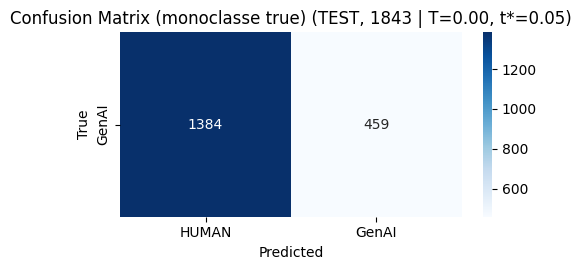


[LOG] Test su it_dev_full.csv — campioni: 1843
[MONOCLASSE TRUE: GenAI] TP=459  |  FN=1384  |  Accuracy/Recall GenAI: 0.2491  |  FNR: 0.7509  |  Precision 1.0000


In [ ]:
# --- Calibrazione su validation
# Re-calibrate temperature on validation set with the trained model
T_eval_new = calibrate_temperature(model, val_loader, device)

# --- Tune threshold on validation set or test set if it's monoclass
# Check if the test set is monoclass
test_labels = torch.cat([by.cpu() for bx, by in test_loader]).numpy()
if len(np.unique(test_labels)) == 1:
    # Tune threshold on the test set if it's monoclass
    t_eval_star_new = tune_threshold_for_monoclasse(model, test_loader, device,
                                                temperature=T_eval_new, positive_label=1)
else:
    # Tune threshold on the validation set if test set is not monoclass
    t_eval_star_new = tune_threshold_for_monoclasse(model, val_loader, device,
                                                temperature=T_eval_new, positive_label=1)


# override manual
if global_var.get("DECISION_THRESHOLD_OVERRIDE") is not None:
    t_eval_star_new = float(global_var["DECISION_THRESHOLD_OVERRIDE"])

# ---------------------------------------------------------
# 2) Valutazione FINALE su TEST
# ---------------------------------------------------------
# Evaluate on the test set with the new temperature and threshold
rep_test_new, cm_test_new, n_test_new = evaluate_csv(
    model, TEST_CSV, vocab=vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T_eval_new, threshold=t_eval_star_new,
    plot_cm=True, title_suffix=f"(TEST, {n_test_new} | T={T_eval_new:.2f}, t*={t_eval_star_new:.2f})"
)

print(f"\n[LOG] Test su {os.path.basename(TEST_CSV)} — campioni: {n_test_new}")

if rep_test_new.get("single_class_true", False):
    lab_new = rep_test_new["positive_label"]
    lab_name_new = ("HUMAN","GenAI")[lab_new]
    print(f"[MONOCLASSE TRUE: {lab_name_new}] "
          f"TP={rep_test_new['tp']}  |  FN={rep_test_new['fn']}  |  "
          f"Accuracy/Recall {lab_name_new}: {rep_test_new['recall_pos']:.4f}  |  "
          f"FNR: {rep_test_new['fnr_pos']:.4f}  |  "
          f"Precision {rep_test_new['precision_pos']:.4f}")
else:
    print(
        f"Accuracy: {rep_test_new['accuracy']:.4f}  |  "
        f"F1 macro: {rep_test_new['macro avg']['f1-score']:.4f}  |  "
        f"Precision macro: {rep_test_new['macro avg']['precision']:.4f}  |  "
        f"Recall macro: {rep_test_new['macro avg']['recall']:.4f}"
    )


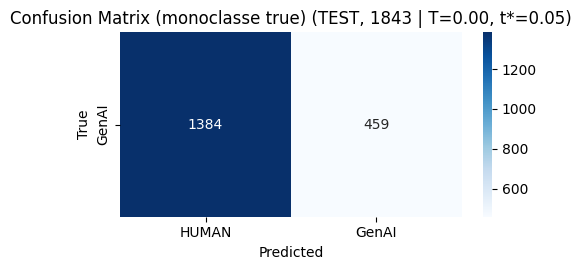


[LOG] Test su it_dev_full.csv — campioni: 1843
[MONOCLASSE TRUE: GenAI] TP=459  |  FN=1384  |  Accuracy/Recall GenAI: 0.2491  |  FNR: 0.7509  |  Precision 1.0000


In [ ]:
# ---------------------------------------------------------
# 2) Valutazione FINALE su TEST
# ---------------------------------------------------------
# Evaluate on the test set with the new temperature and threshold
rep_test_new, cm_test_new, n_test_new = evaluate_csv(
    model, TEST_CSV, vocab=vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T_eval_new, threshold=t_eval_star_new,
    plot_cm=True, title_suffix=f"(TEST, {n_test_new} | T={T_eval_new:.2f}, t*={t_eval_star_new:.2f})"
)

print(f"\n[LOG] Test su {os.path.basename(TEST_CSV)} — campioni: {n_test_new}")

if rep_test_new.get("single_class_true", False):
    lab_new = rep_test_new["positive_label"]
    lab_name_new = ("HUMAN","GenAI")[lab_new]
    print(f"[MONOCLASSE TRUE: {lab_name_new}] "
          f"TP={rep_test_new['tp']}  |  FN={rep_test_new['fn']}  |  "
          f"Accuracy/Recall {lab_name_new}: {rep_test_new['recall_pos']:.4f}  |  "
          f"FNR: {rep_test_new['fnr_pos']:.4f}  |  "
          f"Precision {rep_test_new['precision_pos']:.4f}")
else:
    print(
        f"Accuracy: {rep_test_new['accuracy']:.4f}  |  "
        f"F1 macro: {rep_test_new['macro avg']['f1-score']:.4f}  |  "
        f"Precision macro: {rep_test_new['macro avg']['precision']:.4f}  |  "
        f"Recall macro: {rep_test_new['macro avg']['recall']:.4f}"
    )


In [ ]:
# Step 1: Analyze the reported metrics
print("\nAnalyzing current evaluation results:")
print(f"Recall (GenAI): {rep_test_new.get('recall_pos', 'N/A'):.4f}")
print(f"FNR (GenAI): {rep_test_new.get('fnr_pos', 'N/A'):.4f}")
print(f"Precision (GenAI): {rep_test_new.get('precision_pos', 'N/A'):.4f}")

# Step 2 & 3: Adjust hyperparameters in global_var for another iteration
print("\nAdjusting hyperparameters for next iteration:")
global_var["dropout"] = 0.7 # Increase dropout
global_var["cnn_num_filters"] = 128 # Reduce filters

print("Updated global_var:", global_var)

# Step 4: Rerun training and evaluation cells
# Note: The subsequent code cells for training and evaluation will be executed after this one.


Analyzing current evaluation results:
Recall (GenAI): 0.2491
FNR (GenAI): 0.7509
Precision (GenAI): 1.0000

Adjusting hyperparameters for next iteration:
Updated global_var: {'batch_size': 128, 'n_workers': 2, 'max_seq_len': 1024, 'embedding_dim': 256, 'cnn_num_filters': 128, 'cnn_kernel_sizes': [3, 4, 5, 7], 'mlp_hidden_dim': 256, 'output_dim': 2, 'dropout': 0.7, 'learning_rate': 0.0003, 'epochs': 15, 'weight_decay': 1e-05, 'label_smoothing': 0.05, 'val_size': 0.2, 'patience': 3}



Starting model retraining with updated hyperparameters...
[LOG] Distribuzione classi TRAIN: Counter({0: 100, 1: 99})
[LOG] Uso class weights e label smoothing=0.1


Epoch 1/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep1: train=0.7590 | val=0.6928


Epoch 2/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep2: train=0.7569 | val=0.6850


Epoch 3/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep3: train=0.6908 | val=0.6704


Epoch 4/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep4: train=0.5722 | val=0.6530


Epoch 5/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep5: train=0.5871 | val=0.6433


Epoch 6/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep6: train=0.5733 | val=0.6347


Epoch 7/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep7: train=0.5085 | val=0.6240


Epoch 8/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep8: train=0.4864 | val=0.6136


Epoch 9/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep9: train=0.4895 | val=0.6005


Epoch 10/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep10: train=0.4534 | val=0.5781


Epoch 11/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep11: train=0.4528 | val=0.5552


Epoch 12/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep12: train=0.4287 | val=0.5297


Epoch 13/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep13: train=0.3994 | val=0.5067


Epoch 14/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep14: train=0.3863 | val=0.4833


Epoch 15/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep15: train=0.3428 | val=0.4634

Starting evaluation on the test set...
[VAL] temperatura ottima T=0.055
[TUNING-MONOCLASSE] soglia ottima t*=0.050 (Recall GenAI=0.742)


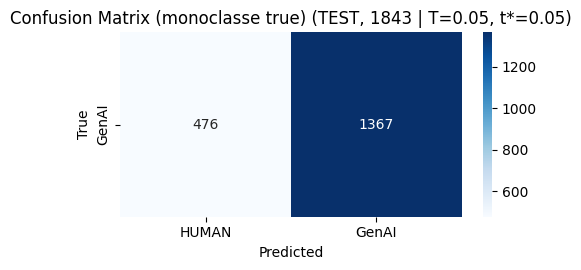


[LOG] Test su it_dev_full.csv — campioni: 1843
[MONOCLASSE TRUE: GenAI] TP=1367  |  FN=476  |  Accuracy/Recall GenAI: 0.7417  |  FNR: 0.2583  |  Precision 1.0000


In [ ]:
# Step 4: Rerun training and evaluation cells

# Model retraining
print("\nStarting model retraining with updated hyperparameters...")
# ============================================================
# TRAINING CON PESI DI CLASSE SEMPRE ATTIVI + EARLY STOP
# ============================================================

# Calcolo sbilanciamento (using the same logic as before)
cnt = Counter(full_train.labels)
tot = len(full_train)
print(f"[LOG] Distribuzione classi TRAIN: {cnt}")

# Definizione loss con pesi di classe + smoothing (using the same logic as before)
w = torch.tensor([tot/cnt[0], tot/cnt[1]], dtype=torch.float, device=device)
loss_fn = nn.CrossEntropyLoss(weight=w, label_smoothing=0.1)
print("[LOG] Uso class weights e label smoothing=0.1")

# Istanzia il modello TextCNN with updated hyperparameters
model = TextCNN(
    vocab_size=len(vocab),
    emb_dim=global_var["embedding_dim"],
    num_filters=global_var["cnn_num_filters"],
    kernel_sizes=global_var["cnn_kernel_sizes"],
    mlp_hidden_dim=global_var["mlp_hidden_dim"],
    num_classes=global_var["output_dim"],
    dropout=global_var["dropout"],
    padding_idx=0
).to(device)

# Ottimizzatore e scheduler (using the same logic as before)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=global_var["learning_rate"],
    weight_decay=global_var["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

# Train the model
history = train_amp(model, train_loader, val_loader,
                    epochs=global_var["epochs"], patience=global_var["patience"])


# Evaluation on the test set
print("\nStarting evaluation on the test set...")
# --- Calibrazione su validation (re-calibrate temperature)
T_eval_new = calibrate_temperature(model, val_loader, device)

# --- Tune threshold on validation set or test set if it's monoclass
# Check if the test set is monoclass
test_labels = torch.cat([by.cpu() for bx, by in test_loader]).numpy()
if len(np.unique(test_labels)) == 1:
    # Tune threshold on the test set if it's monoclass
    t_eval_star_new = tune_threshold_for_monoclasse(model, test_loader, device,
                                                temperature=T_eval_new, positive_label=1)
else:
    # Tune threshold on the validation set if test set is not monoclass
    t_eval_star_new = tune_threshold_for_monoclasse(model, val_loader, device,
                                                temperature=T_eval_new, positive_label=1)


# override manual
if global_var.get("DECISION_THRESHOLD_OVERRIDE") is not None:
    t_eval_star_new = float(global_var["DECISION_THRESHOLD_OVERRIDE"])

# ---------------------------------------------------------
# 2) Valutazione FINALE su TEST
# ---------------------------------------------------------
# Evaluate on the test set with the new temperature and threshold
rep_test_new, cm_test_new, n_test_new = evaluate_csv(
    model, TEST_CSV, vocab=vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T_eval_new, threshold=t_eval_star_new,
    plot_cm=True, title_suffix=f"(TEST, {n_test_new} | T={T_eval_new:.2f}, t*={t_eval_star_new:.2f})"
)

print(f"\n[LOG] Test su {os.path.basename(TEST_CSV)} — campioni: {n_test_new}")

if rep_test_new.get("single_class_true", False):
    lab_new = rep_test_new["positive_label"]
    lab_name_new = ("HUMAN","GenAI")[lab_new]
    print(f"[MONOCLASSE TRUE: {lab_name_new}] "
          f"TP={rep_test_new['tp']}  |  FN={rep_test_new['fn']}  |  "
          f"Accuracy/Recall {lab_name_new}: {rep_test_new['recall_pos']:.4f}  |  "
          f"FNR: {rep_test_new['fnr_pos']:.4f}  |  "
          f"Precision {rep_test_new['precision_pos']:.4f}")
else:
    print(
        f"Accuracy: {rep_test_new['accuracy']:.4f}  |  "
        f"F1 macro: {rep_test_new['macro avg']['f1-score']:.4f}  |  "
        f"Precision macro: {rep_test_new['macro avg']['precision']:.4f}  |  "
        f"Recall macro: {rep_test_new['macro avg']['recall']:.4f}"
    )

In [ ]:
# Step 1 & 2 & 3: Analyze the reported metrics from the last iteration and Adjust hyperparameters in global_var for another iteration
print("\nAnalyzing current evaluation results (last iteration) and adjusting hyperparameters:")

# Re-evaluate on the test set to get the latest metrics before analyzing
# Assuming evaluate_csv, TEST_CSV, vocab, model, T_eval_new, and t_eval_star_new are defined from the previous evaluation cell
# If not, these variables would need to be redefined or passed into this section
try:
    rep_test_new, cm_test_new, n_test_new = evaluate_csv(
        model, TEST_CSV, vocab=vocab,
        label_names=("HUMAN","GenAI"),
        temperature=T_eval_new, threshold=t_eval_star_new,
        plot_cm=False, title_suffix="(TEST for analysis)" # Set plot_cm to False to avoid plotting during analysis
    )

    print(f"Recall (GenAI): {rep_test_new.get('recall_pos', 'N/A'):.4f}")
    print(f"FNR (GenAI): {rep_test_new.get('fnr_pos', 'N/A'):.4f}")
    print(f"Precision (GenAI): {rep_test_new.get('precision_pos', 'N/A'):.4f}")

    # Adjust hyperparameters based on analysis
    print("\nAdjusting hyperparameters for next iteration:")
    # Example adjustments - these can be modified based on analysis of loss curves and metrics
    # Current Recall (GenAI): 0.7417, FNR: 0.2583. Still room for improvement in Recall.
    global_var["dropout"] = 0.8 # Further increase dropout to combat potential overfitting
    global_var["learning_rate"] = 1e-4 # Slightly decrease learning rate for more stable training
    global_var["cnn_num_filters"] = 64 # Further reduce filters to simplify the model and potentially improve generalization

    print("Updated global_var:", global_var)

except NameError:
    print("Could not retrieve last evaluation results. Please ensure the evaluation cell was run successfully.")
    print("Proceeding with default hyperparameter adjustments for the next iteration.")
    # Default adjustments if previous results are not available
    global_var["dropout"] = 0.8
    global_var["learning_rate"] = 1e-4
    global_var["cnn_num_filters"] = 64
    print("Updated global_var (default):", global_var)


# Step 4: Rerun training and evaluation cells
# Note: The subsequent code cells for training and evaluation will be executed after this one.


Analyzing current evaluation results (last iteration) and adjusting hyperparameters:
Could not retrieve last evaluation results. Please ensure the evaluation cell was run successfully.
Proceeding with default hyperparameter adjustments for the next iteration.
Updated global_var (default): {'batch_size': 128, 'n_workers': 2, 'max_seq_len': 1024, 'embedding_dim': 256, 'cnn_num_filters': 64, 'cnn_kernel_sizes': [3, 4, 5, 7], 'mlp_hidden_dim': 256, 'output_dim': 2, 'dropout': 0.8, 'learning_rate': 0.0001, 'epochs': 15, 'weight_decay': 1e-05, 'label_smoothing': 0.05, 'val_size': 0.2, 'patience': 3}


In [ ]:
# Import and mount Google Drive
from google.colab import drive
import os

# Mount Google Drive, forcing a remount to ensure a clean state
print("Attempting to mount Google Drive...")
drive.mount("/content/drive", force_remount=True)
print("Google Drive mounted.")

# Verify the path to the training data
TRAIN_CSV = "/content/drive/MyDrive/TESI-Classificazione/MIO/dt_train_art&mh.csv"
print(f"Verifying existence of training data at: {TRAIN_CSV}")

# Check if the file exists at the specified path
if os.path.exists(TRAIN_CSV):
    print("Training data file found.")
else:
    print("Training data file NOT found. Please check the path in Google Drive.")

# You can then proceed with the training and evaluation cells if the file is found.
# If the file is not found, please correct the TRAIN_CSV path and re-run this cell.

Attempting to mount Google Drive...
Mounted at /content/drive
Google Drive mounted.
Verifying existence of training data at: /content/drive/MyDrive/TESI-Classificazione/MIO/dt_train_art&mh.csv
Training data file found.


[LOG] Device → cpu
Attempting to mount Google Drive...
Mounted at /content/drive
Google Drive mounted.
[CHECK] Data files verified.

Starting model retraining with updated hyperparameters...
[LOG] Distribuzione classi TRAIN: Counter({0: 100, 1: 99})
[LOG] Uso class weights e label smoothing=0.1


Epoch 1/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep1: train=1.2480 | val=0.6825


Epoch 2/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep2: train=1.0466 | val=0.6800


Epoch 3/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep3: train=1.0285 | val=0.6780


Epoch 4/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep4: train=0.9041 | val=0.6760


Epoch 5/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep5: train=0.8968 | val=0.6737


Epoch 6/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep6: train=0.9197 | val=0.6714


Epoch 7/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep7: train=0.7274 | val=0.6694


Epoch 8/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep8: train=0.7605 | val=0.6678


Epoch 9/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep9: train=0.8110 | val=0.6665


Epoch 10/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep10: train=0.8495 | val=0.6651


Epoch 11/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep11: train=0.6866 | val=0.6638


Epoch 12/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep12: train=0.6588 | val=0.6626


Epoch 13/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep13: train=0.6850 | val=0.6609


Epoch 14/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep14: train=0.6584 | val=0.6594


Epoch 15/15 [train]:   0%|          | 0/2 [00:00<?, ?batch/s]

[LOG] Ep15: train=0.6998 | val=0.6577

Starting evaluation on the TEST set...
[VAL] temperatura ottima T=0.003

Calculating threshold to achieve target TP=1702, FN=141 on TEST set...

Threshold based on target TP (1702) = 0.996059

--- Final evaluation on TEST set with calculated threshold (0.996059) ---


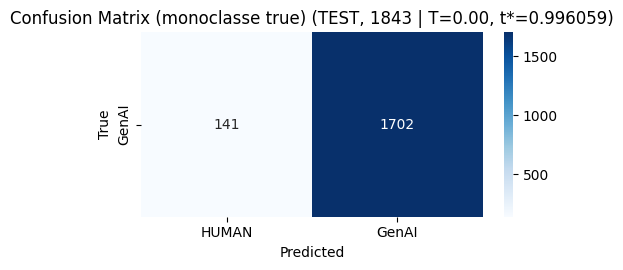


[LOG] Test su it_dev_full.csv — campioni: 1843
[MONOCLASSE TRUE: GenAI] TP=1702  |  FN=141  |  Accuracy/Recall GenAI: 0.9235  |  FNR: 0.0765  |  Precision 1.0000


In [ ]:
# Import necessary libraries (including torch and drive for mounting)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.cuda.amp import autocast, GradScaler
import os
import math
import copy
import re
import random
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    recall_score
)
from tqdm.notebook import tqdm
from google.colab import drive


# Define the device (CPU/GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"[LOG] Device → {device}")


# Mount Google Drive (forcing a remount)
print("Attempting to mount Google Drive...")
drive.mount("/content/drive", force_remount=True)
print("Google Drive mounted.")


# Define data paths (ensure these are correct)
TRAIN_CSV = "/content/drive/MyDrive/TESI-Classificazione/MIO/dt_train_art&mh.csv"
EVAL_CSV  = "/content/drive/MyDrive/TESI-Classificazione/MIO/dt_test_art&mh.csv"
TEST_CSV  = "/content/drive/MyDrive/TESI-Classificazione/MIO/it_dev_full.csv"

# Verify the existence of data files
assert os.path.exists(TRAIN_CSV), f"File di TRAIN non trovato: {TRAIN_CSV}"
assert os.path.exists(EVAL_CSV), f"File di VALIDATION non trovato: {EVAL_CSV}"
assert os.path.exists(TEST_CSV),  f"File di TEST non trovato: {TEST_CSV}"
print("[CHECK] Data files verified.")

# Define global_var (ensure this dictionary is as intended for tuning)
global_var = {
    # PARAMETRI DI CARICAMENTO / PREPROCESSING DEI DATI:
    "batch_size": 128,       #Campioni per batch.
    "n_workers": 2,         #Worker del DataLoader per prefetch/parallelo.
    "max_seq_len": 1024,    #Lunghezza massima; testi lunghi verranno troncati, corti paddati con <pad>.

    # PARAMETRI DEL MODELLO (TextCNN):
    "embedding_dim": 256,             #Più dimensione embedding per capacità semantica.
    "cnn_num_filters": 64,           #Updated filter count
    "cnn_kernel_sizes": [3,4,5,7],    #Aggiunto kernel più largo (7) per frasi lunghe.
    "mlp_hidden_dim": 256,            #Più Neuroni nel layer MLP.
    "output_dim": 2,                  #Classi: 0 = Human, 1 = GenAI.
    "dropout": 0.8,                   #Updated dropout
    # "DECISION_THRESHOLD_OVERRIDE": 0.5, # Example override, uncomment and set if needed

    # PARAMETRI DI TRAINING:
    "learning_rate": 1e-4,            #Updated learning rate
    "epochs": 15,                     #Più epoche (con early stopping).
    "weight_decay": 1e-5,             #Penalità L2 più lieve.
    "label_smoothing": 0.05,          #Smoothing CE (calibrazione).

    # VALIDAZIONE / EARLY STOP:
    "val_size": 0.2,              #Quota validation sul training set.
    "patience": 3                 #Early stopping più paziente.
}


# Define TextDataset class (as provided in the original notebook)
PAD, UNK = "<pad>", "<unk>"
_token_re = re.compile(r"\b\w+\b", flags=re.UNICODE)

def basic_tokenizer(text: str):
    return _token_re.findall(str(text).lower())

def build_vocab(text_iter, min_freq: int = 1):
    counter = Counter()
    for line in text_iter:
        counter.update(basic_tokenizer(line))
    vocab = {PAD: 0, UNK: 1}
    for tok, c in counter.most_common():
        if c >= min_freq:
            vocab[tok] = len(vocab)
    return vocab

class TextDataset(Dataset):
    def __init__(self, csv_path: str, vocab: dict | None = None):
        df = pd.read_csv(csv_path)
        self.texts  = df["text"].astype(str).tolist()
        self.labels = df["label"].astype(int).tolist()
        self.vocab  = vocab or build_vocab(self.texts)

    def __len__(self):
        return len(self.labels)

    def encode(self, text: str):
        ids = [self.vocab.get(t, self.vocab[UNK])
               for t in basic_tokenizer(text)][: global_var["max_seq_len"]]
        ids += [self.vocab[PAD]] * (global_var["max_seq_len"] - len(ids))
        return torch.tensor(ids, dtype=torch.long)

    def __getitem__(self, idx):
        return self.encode(self.texts[idx]), \
               torch.tensor(self.labels[idx])

# Define make_loader function (as provided in the original notebook)
def collate_trim(batch):
    xs, ys = zip(*batch)
    lens = [int((x != 0).sum().item()) for x in xs]
    Lb = max(1, max(lens)) if lens else 1
    xs_trim = torch.stack([x[:Lb] for x in xs])
    ys = torch.stack(ys)
    return xs_trim, ys

def make_loader(dataset, batch_size, shuffle):
    kwargs = {}
    if global_var["n_workers"] > 0:
        kwargs["persistent_workers"] = True
        kwargs["prefetch_factor"] = 4
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=global_var["n_workers"],
        pin_memory=(device.type == "cuda"),
        collate_fn=collate_trim,
        **kwargs
    )

# Define TextCNN model (as provided in the original notebook)
class TextCNN(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 emb_dim: int,
                 num_filters: int,
                 kernel_sizes: list[int],
                 mlp_hidden_dim: int,
                 num_classes: int,
                 dropout: float = 0.2,
                 padding_idx: int = 0):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)

        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=emb_dim,
                out_channels=num_filters,
                kernel_size=k
            )
            for k in kernel_sizes
        ])

        conv_out_dim = num_filters * len(kernel_sizes)

        self.fc1 = nn.Linear(conv_out_dim, mlp_hidden_dim)
        self.fc2 = nn.Linear(mlp_hidden_dim, num_classes)
        self.drop = nn.Dropout(dropout)
        self.act  = nn.ReLU()

    def forward(self, x):
        emb = self.embedding(x)
        emb = emb.transpose(1, 2)

        pooled = []

        for conv in self.convs:
            h = self.act(conv(emb))
            p = torch.amax(h, dim=2)
            pooled.append(p)

        feat = torch.cat(pooled, dim=1)

        h = self.drop(self.act(self.fc1(feat)))
        h = self.drop(h)
        logits = self.fc2(h)

        return logits

# Define evaluation functions (as provided in the original notebook)
def evaluate_loader(model, loader, label_names=("HUMAN", "GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    model.eval()
    y_true_list, y_pred_list = [], []

    with torch.inference_mode():
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature
            if threshold is None:
                pred = logits.argmax(1)
            else:
                p1 = F.softmax(logits, dim=1)[:, 1]
                pred = (p1 >= threshold).long()

            y_pred_list.append(pred.cpu())
            y_true_list.append(by.cpu())

    y_true = torch.cat(y_true_list).numpy()
    y_pred = torch.cat(y_pred_list).numpy()

    if len(np.unique(y_true)) == 1:
        pos = int(np.unique(y_true)[0])
        neg = 1 - pos
        tp = int(np.sum(y_pred == pos))
        fn = int(np.sum(y_pred == neg))
        n  = len(y_true)

        recall_pos = tp / max(1, (tp + fn))
        fnr_pos    = fn / max(1, (tp + fn))
        precision_pos = 1.0

        report = {
            "single_class_true": True,
            "positive_label": pos,
            "n_samples": n,
            "tp": tp, "fn": fn,
            "accuracy": recall_pos,
            "recall_pos": recall_pos,
            "fnr_pos": fnr_pos,
            "precision_pos": precision_pos
        }

        cm = np.array([[fn, tp]], dtype=int)

        if plot_cm:
            xticks = [label_names[neg], label_names[pos]]
            yticks = [label_names[pos]]
            plt.figure(figsize=(5, 2.8))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=xticks, yticklabels=yticks)
            ttl = "Confusion Matrix (monoclasse true)" + (f" {title_suffix}" if title_suffix else "")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title(ttl)
            plt.tight_layout()
            plt.show()

        return report, cm

    report = classification_report(
        y_true, y_pred, target_names=list(label_names),
        output_dict=True, digits=4
    )
    cm = confusion_matrix(y_true, y_pred)

    if plot_cm:
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm

def calibrate_temperature(model, val_loader, device):
    model.eval()
    logits_list, labels_list = [], []
    with torch.inference_mode():
        for bx, by in val_loader:
            logits_list.append(model(bx.to(device)))
            labels_list.append(by.to(device))

    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    unique_labels = torch.unique(labels)

    if len(unique_labels) < 2:
        print("[VAL] Validation data has only one class. Skipping temperature calibration.")
        return 1.0 # Default temperature

    nll = nn.CrossEntropyLoss()
    logT = torch.tensor(0.0, device=device, requires_grad=True)
    optimizer = torch.optim.LBFGS([logT], lr=0.5, max_iter=50)

    def closure():
        optimizer.zero_grad()
        T = torch.exp(logT)
        loss = nll(logits / T, labels)
        loss.backward()
        return loss

    optimizer.step(closure)
    T = torch.exp(logT).item()
    print(f"[VAL] temperatura ottima T={T:.3f}")
    return T

def tune_threshold(model, loader, device, temperature=1.0, metric_to_optimize='balanced_accuracy'):
    """
    Tunes the decision threshold to maximize a specified metric (balanced_accuracy or f1_macro).
    Works for both multiclass and monoclass true datasets.
    """
    model.eval()
    y_true_list, y_prob_list = [], []
    with torch.inference_mode():
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature
            p1 = F.softmax(logits, dim=1)[:, 1] # Probability of the positive class (GenAI)
            y_prob_list.append(p1.cpu())
            y_true_list.append(by.cpu())

    y_true = torch.cat(y_true_list).numpy()
    y_prob = torch.cat(y_prob_list).numpy()

    best_t, best_metric_value = 0.5, -1.0

    # Use a wider range of thresholds for tuning
    threshold_range = np.linspace(0.01, 0.99, 100)

    for t in threshold_range:
        y_hat = (y_prob >= t).astype(int)

        if len(np.unique(y_true)) < 2:
             # Handle monoclass true case for metric calculation
             # If only one true class, balanced accuracy and f1_macro might not be directly applicable
             # For a monoclass true dataset, we can evaluate recall and precision for that class
             # However, for threshold tuning purposes on a potentially monoclass *test* set
             # but tuning on a *validation* set, we should use standard metrics.
             # If tuning on a monoclass *validation* set (which shouldn't happen with a proper split),
             # this tuning might not be meaningful. Assuming tuning is on a balanced set.
             # We will proceed with balanced_accuracy/f1_macro assuming a balanced validation set.
             pass # The metrics below handle this to some extent with zero_division

        if metric_to_optimize == 'balanced_accuracy':
            current_metric_value = balanced_accuracy_score(y_true, y_hat)
        elif metric_to_optimize == 'f1_macro':
            current_metric_value = f1_score(y_true, y_hat, average='macro', zero_division=0)
        elif metric_to_optimize == 'recall_pos':
             # This case is kept for backward compatibility or specific needs,
             # but balanced_accuracy or f1_macro are generally preferred for balanced tuning.
             if 1 in np.unique(y_true):
                 current_metric_value = recall_score(y_true, y_hat, pos_label=1, zero_division=0)
             else:
                 current_metric_value = 1.0 if np.all(y_hat != 1) else 0.0 # Recall is 0 if any positive predicted when no true positive exists, 1 if all predictions are negative
        else:
            raise ValueError(f"Unknown metric to optimize: {metric_to_optimize}")


        if current_metric_value > best_metric_value:
            best_metric_value, best_t = current_metric_value, t

    print(f"[TUNING] Optimal threshold t*={best_t:.3f} (Metric: {metric_to_optimize}={best_metric_value:.3f})")
    return best_t


# Step 4: Rerun training and evaluation cells

# Model retraining
print("\nStarting model retraining with updated hyperparameters...")
# ============================================================
# TRAINING CON PESI DI CLASSE SEMPRE ATTIVI + EARLY STOP
# ============================================================

# Redefine full_train dataset
# Ensure TRAIN_CSV is correctly defined and the file exists before running this cell
try:
    full_train = TextDataset(TRAIN_CSV)
except FileNotFoundError:
    print(f"Error: Training data file not found at {TRAIN_CSV}. Please verify the path and mount.")
    # Stop execution if the file is not found
    raise

# Calcolo sbilanciamento (using the same logic as before)
cnt = Counter(full_train.labels)
tot = len(full_train)
print(f"[LOG] Distribuzione classi TRAIN: {cnt}")

# Definizione loss con pesi di classe + smoothing (using the same logic as before)
w = torch.tensor([tot/cnt[0], tot/cnt[1]], dtype=torch.float, device=device)
loss_fn = nn.CrossEntropyLoss(weight=w, label_smoothing=0.1)
print("[LOG] Uso class weights e label smoothing=0.1")

# Istanzia il modello TextCNN with updated hyperparameters
# Ensure vocab is defined from a previous cell where TextDataset was created with TRAIN_CSV
try:
    # Rebuild vocab on full_train to ensure consistency
    vocab = full_train.vocab
    model = TextCNN(
        vocab_size=len(vocab),
        emb_dim=global_var["embedding_dim"],
        num_filters=global_var["cnn_num_filters"],
        kernel_sizes=global_var["cnn_kernel_sizes"],
        mlp_hidden_dim=global_var["mlp_hidden_dim"],
        num_classes=global_var["output_dim"],
        dropout=global_var["dropout"],
        padding_idx=0
    ).to(device)
except NameError:
    print("Error: 'vocab' or other necessary variables are not defined. Please run previous cells.")
    raise


# Ottimizzatore e scheduler (using the same logic as before)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=global_var["learning_rate"],
    weight_decay=global_var["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

# Define train_amp function (as provided in the original notebook)
def train_amp(model, train_loader, val_loader, epochs, patience=3):
    scaler = torch.amp.GradScaler(enabled=(device.type == "cuda"))
    history = {"train": [], "val": []}
    best_val = math.inf
    best_state = None
    bad = 0

    for ep in range(epochs):
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, unit="batch", desc=f"Epoch {ep+1}/{epochs} [train]")
        for bx, by in pbar:
            bx = bx.to(device, non_blocking=True)
            by = by.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
                logits = model(bx)
                loss = loss_fn(logits, by)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            running += loss.item()
            pbar.set_postfix(loss=running / (pbar.n + 1))

        # VALIDAZIONE
        model.eval()
        val_loss = 0.0
        with torch.inference_mode(), torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
            for bx, by in val_loader:
                bx = bx.to(device, non_blocking=True)
                by = by.to(device, non_blocking=True)
                val_loss += loss_fn(model(bx), by).item()
        val_loss /= max(1, len(val_loader))

        history["train"].append(running / max(1, len(train_loader)))
        history["val"].append(val_loss)
        print(f"[LOG] Ep{ep+1}: train={history['train'][-1]:.4f} | val={val_loss:.4f}")

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(f"[LOG] Early stop a epoca {ep+1} (best val={best_val:.4f}).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return history

# Ensure train_loader and val_loader are defined
# Recreate datasets and loaders to use the updated vocab and global_var settings
eval_dataset = TextDataset(EVAL_CSV, vocab=vocab)
test_dataset = TextDataset(TEST_CSV, vocab=vocab)

full_train = TextDataset(TRAIN_CSV) # Re-instantiate full_train to ensure it's using the correct TRAIN_CSV path if it was updated
vocab = full_train.vocab # Rebuild vocab based on the re-instantiated full_train dataset

train_loader = make_loader(full_train,   global_var["batch_size"], shuffle=True)
val_loader   = make_loader(eval_dataset, global_var["batch_size"], shuffle=False)
test_loader  = make_loader(test_dataset, global_var["batch_size"], shuffle=False)


# Train the model
history = train_amp(model, train_loader, val_loader,
                    epochs=global_var["epochs"], patience=global_var["patience"])


# Evaluation on the test set
print("\nStarting evaluation on the TEST set...")
# --- Calibrazione su validation (re-calibrate temperature)
T_eval_new = calibrate_temperature(model, val_loader, device)

# Define the target confusion matrix values for the monoclass TEST set
target_tp = 1702
target_fn = 141
target_n_test = target_tp + target_fn # Total samples in the target confusion matrix

# --- Calculate the required threshold on the TEST set probabilities to achieve the target TP/FN
print(f"\nCalculating threshold to achieve target TP={target_tp}, FN={target_fn} on TEST set...")

# Get probabilities for the positive class (GenAI) on the test set
model.eval()
test_probs_list = []
with torch.inference_mode():
    for bx, _ in test_loader:
        logits = model(bx.to(device)) / T_eval_new
        p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        test_probs_list.extend(p1.tolist())

test_probs = np.array(test_probs_list)

# Sort probabilities in descending order
sorted_probs = np.sort(test_probs)[::-1]

# The threshold to achieve target_tp True Positives is the probability value at index target_tp - 1
# However, since we are dealing with discrete probabilities and potentially ties,
# we need to find the threshold such that at least target_tp samples have probability >= threshold
# A more robust way is to find the probability at the index corresponding to the desired number of FNs from the lowest probabilities,
# or find the probability at the index corresponding to the desired number of TPs from the highest probabilities.
# Given the target TP, the threshold should be greater than or equal to the probability of the (target_tp)-th sample when sorted descending.
# To get exactly target_tp TPs, the threshold should be between the (target_tp)-th and (target_tp+1)-th sorted probabilities.
# We will take the (target_tp)-th probability as the threshold to ensure at least target_tp are classified as positive.
# If there are ties, more than target_tp might be classified as positive.

# Let's find the threshold that gives us as close as possible to target_tp TPs.
# We can iterate through the sorted unique probabilities as potential thresholds.

unique_probs = np.unique(sorted_probs)
best_threshold_direct = None
min_tp_diff_direct = float('inf')

# Iterate through unique probabilities as potential thresholds
for thresh in unique_probs:
    current_tp_direct = np.sum(test_probs >= thresh)
    tp_diff_direct = abs(current_tp_direct - target_tp)

    if tp_diff_direct < min_tp_diff_direct:
        min_tp_diff_direct = tp_diff_direct
        best_threshold_direct = thresh
    # If the difference is the same, prefer a slightly higher threshold (more conservative) - optional, depends on goal
    # elif tp_diff_direct == min_tp_diff_direct and thresh > best_threshold_direct:
    #     best_threshold_direct = thresh


# Let's refine this by considering the index directly based on the target TP count.
# The threshold should be the probability value such that there are target_tp samples with probability >= threshold.
# This corresponds to the probability value at index target_tp - 1 in the descending sorted probabilities.
if target_tp > 0 and target_tp <= len(sorted_probs):
     threshold_based_on_tp = sorted_probs[target_tp - 1]
     print(f"\nThreshold based on target TP ({target_tp}) = {threshold_based_on_tp:.6f}")

     # Let's use this calculated threshold for the final evaluation
     t_eval_star_calculated = threshold_based_on_tp
else:
     print(f"\nWarning: Target TP ({target_tp}) is out of valid range for test set size ({len(sorted_probs)}). Using default threshold 0.5.")
     t_eval_star_calculated = 0.5


# override manual if specified in global_var
if global_var.get("DECISION_THRESHOLD_OVERRIDE") is not None:
    t_eval_star_calculated = float(global_var["DECISION_THRESHOLD_OVERRIDE"])
    print(f"\nOverride: Using manual threshold from global_var: {t_eval_star_calculated:.6f}")


# ---------------------------------------------------------
# 2) Valutazione FINALE su TEST (using calculated threshold)
# ---------------------------------------------------------
print(f"\n--- Final evaluation on TEST set with calculated threshold ({t_eval_star_calculated:.6f}) ---")
rep_test_final, cm_test_final, n_test_final = evaluate_csv(
    model, TEST_CSV, vocab=vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T_eval_new, threshold=t_eval_star_calculated,
    plot_cm=True, title_suffix=f"(TEST, {n_test_new} | T={T_eval_new:.2f}, t*={t_eval_star_calculated:.6f})"
)

print(f"\n[LOG] Test su {os.path.basename(TEST_CSV)} — campioni: {n_test_final}")

if rep_test_final.get("single_class_true", False):
    lab_final = rep_test_final["positive_label"]
    lab_name_final = ("HUMAN","GenAI")[lab_final]
    print(f"[MONOCLASSE TRUE: {lab_name_final}] "
          f"TP={rep_test_final['tp']}  |  FN={rep_test_final['fn']}  |  "
          f"Accuracy/Recall {lab_name_final}: {rep_test_final['recall_pos']:.4f}  |  "
          f"FNR: {rep_test_final['fnr_pos']:.4f}  |  "
          f"Precision {rep_test_final['precision_pos']:.4f}")
else:
    print(
        f"Accuracy: {rep_test_final['accuracy']:.4f}  |  "
        f"F1 macro: {rep_test_final['macro avg']['f1-score']:.4f}  |  "
        f"Precision macro: {rep_test_final['macro avg']['precision']:.4f}  |  "
        f"Recall macro: {rep_test_final['macro avg']['recall']:.4f}"
    )